In [1]:
from simulator_brian import create_connection_matrix
import os
import imp
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
import elephant
import pickle as pkl
from brian2 import *
import pdb
import sys
import pandas as pd

In [2]:
data_path = '/home/jovyan/work/instrumentalVariable/test_data_sim_big/'
param_module = 'params_test_big_brian2.py'
os.makedirs(data_path, exist_ok=True)
jobname = param_module.replace('.py', '')
currdir = '/home/jovyan/work/instrumentalVariable/causal-optogenetics-paper-data/'
f, p, d = imp.find_module(jobname, [currdir])
p = imp.load_module(jobname, f, p, d).parameters

### Set neurons


In [3]:
eqs = '''dV_m/dt = (g_L*(E_L-V_m)+Ie+Ii+I+Ix)/(C_m) : volt
         Ie = ge*(E_ex-V_m) : amp
         Ii = gi*(E_in-V_m) : amp
         dge/dt = -ge/(tau_syn_ex) : siemens
         dgi/dt = -gi/(tau_syn_in) : siemens
         Ix = sizes*0.5*(1+sin(2*pi*rates*t)) : amp
         rates : Hz
         sizes : amp
         I : amp'''
nodes = NeuronGroup(
    p['N_neurons'],
    model=eqs,
    threshold='V_m > V_th',
    reset='V_m = V_reset',
    refractory=p['t_ref'],
    namespace=p,
    method='euler',
)

nodes.sizes = p['s_sin']
nodes.rates= p['r_sin']

p['C_ex'] = int(p['eps'] * p['N_ex'])
p['C_in'] = int(p['eps'] * p['N_in'])
n = p['tau_syn_in'] * abs(p['E_L'] - p['E_in'])
d = p['J_ex'] * p['tau_syn_ex'] * abs(p['E_L'] - p['E_ex'])
p['J_in'] = p['g'] * d / n

nodes_ex = nodes[:p['N_ex']]
nodes_in = nodes[p['N_ex']:]

nodes_ex_stim = nodes_ex[:p['stim_N_ex']]

### Set connections from matrix

In [4]:
m = create_connection_matrix(p, p['msd'])

# store connections
with open(str(data_path)+'/'+'m.pkl', 'wb') as f:
            pkl.dump(m, f)

  0%|          | 0/4000 [00:00<?, ?it/s]WARNING    /opt/conda/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1025: UserWarning: Unknown ufunc 'clip' in __array_prepare__
  warn("Unknown ufunc '%s' in __array_prepare__" % uf.__name__)
 [py.warnings]
WARNING    /opt/conda/lib/python3.7/site-packages/brian2/units/fundamentalunits.py:1060: UserWarning: Unknown ufunc 'clip' in __array_wrap__
  warn("Unknown ufunc '%s' in __array_wrap__" % uf.__name__)
 [py.warnings]
  5%|▍         | 189/4000 [00:00<00:02, 1886.80it/s]

Finding excitatory and inhibitory projections
J_ex =  0.68 nS C_ex =  320 J_in =  12.852 nS C_in =  80


100%|██████████| 4000/4000 [00:01<00:00, 2097.70it/s]


In [5]:
syn_ex = Synapses(
    nodes_ex,
    nodes,
    model='w:siemens',
    on_pre='ge+=w',
    delay=p['syn_delay'])

syn_in = Synapses(
    nodes_in,
    nodes,
    model='w:siemens',
    on_pre='gi+=w',
    delay=p['syn_delay'])

N_ex = p['N_ex']
j, i = np.where(m)
j_ex, i_ex = j[i<N_ex], i[i<N_ex]
j_in, i_in = j[i>=N_ex], i[i>=N_ex]       

syn_ex.connect(i=i_ex, j=j_ex)
syn_ex.w = m[j_ex, i_ex]

syn_in.connect(i=i_in-N_ex, j=j_in)
syn_in.w = m[j_in, i_in]

### Set background stimulation

In [6]:
poissInp = PoissonInput(
    nodes, 'ge',
    N=p['N_p'],
    rate=p['rate_p'],
    weight=p['J_ex'])

### Set spike monitors

In [7]:
# 1 for times without stim
spk_mon1 = SpikeMonitor(nodes)

# 2 for stimulation periods
spk_mon2 = SpikeMonitor(nodes)
spk_mon2.active = False

# population rate monitor
r_mon = PopulationRateMonitor(nodes)

### Simulate

In [8]:
#nodes_ex_stim_i = np.array(nodes_ex_stim.i)

# find last index +1 of stim supgroup
idx_stop_pl_1 = nodes_ex_stim.stop
# make sure that stim subgroups starts with 0
assert nodes_ex_stim.start == 0


@network_operation(when='end')
def stop_for_spikes():
#    if len(nodes_ex_stim.spikes):
#    if len(np.in1d(nodes.spikes, nodes_ex_stim_i)):
    # .spikes is not subgroup specific
    # therefore we have to manually check whether any of the occuring spikes
    # is from the subgroup.
    if len(nodes.spikes) and np.searchsorted(nodes.spikes, idx_stop_pl_1)>0:
        stop()

In [9]:
# run init time without stimulation
stop_for_spikes.active = False
run(p['init_simtime'])
sys.stdout.write('\r'+str(defaultclock.t/ms))
t2 = defaultclock.t/ms

500.0

In [28]:
t1, i1 = np.array(spk_mon1.t), np.array(spk_mon1.i)
r = r_mon.smooth_rate(width=10*ms)

(0, 20)

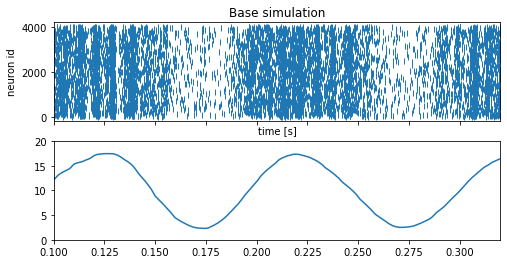

In [30]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4))
ax[0].plot(spk_mon1.t/second, spk_mon1.i, '|')
ax[0].set_title('Base simulation')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('neuron id')

ax[0].set_xlim(0.1, 0.32)

ax[1].plot(np.arange(0*ms, defaultclock.t, defaultclock.dt), r)
ax[1].set_ylim([0, 20])

(0.0, 20)

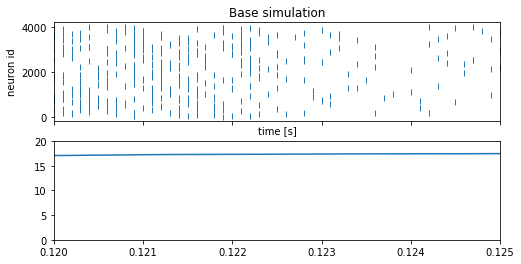

In [32]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4))
ax[0].plot(spk_mon1.t/second, spk_mon1.i, '|')
ax[0].set_title('Base simulation')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('neuron id')

ax[0].set_xlim(0.12, 0.125)

ax[1].plot(np.arange(0*ms, defaultclock.t, defaultclock.dt), r)
ax[1].set_ylim([0., 20])

### Store spikes

In [ ]:
t1, i1 = np.array(spk_mon1.t), np.array(spk_mon1.i)
with open(str(data_path) + '/' + 'spks1.csv', 'w') as f:
        pd.DataFrame({'t': t1, 'id': i1.astype(int)}
        ).to_csv(f, header=False, index=False)